In [3]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [4]:
bd = pd.read_csv('Expanded_data_with_more_features.csv')

In [3]:
bd.head()

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75


In [112]:
df = bd[['Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep', 'ParentMaritalStatus', 'PracticeSport', 'IsFirstChild', 'NrSiblings', 'TransportMeans', 'WklyStudyHours', 'MathScore', 'ReadingScore', 'WritingScore']]

In [113]:
df['TransportMeans'].fillna('private', inplace=True)

In [114]:
df.dropna(inplace=True)

In [115]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Выделим признаки и целевую переменную
X = df.drop(columns=['MathScore', 'ReadingScore', 'WritingScore'])
y = df['MathScore']

# Разделим на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определим категориальные признаки
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Создаем пул данных с указанием категориальных признаков
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

In [116]:
# Создаем модель CatBoost для регрессии
model = CatBoostRegressor(
    iterations=5000,         # Количество итераций
    learning_rate=1,         # Шаг обучения
    depth=3,                 # Глубина деревьев
    cat_features=categorical_features,
    verbose=100,             # Показ прогресса каждые 100 итераций
    random_seed=52,
)

# Обучаем модель
model.fit(train_pool, eval_set=test_pool, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 13.8704240	test: 13.8025847	best: 13.8025847 (0)	total: 4.14ms	remaining: 20.7s
100:	learn: 12.7295902	test: 12.8478777	best: 12.8143789 (30)	total: 254ms	remaining: 12.3s
200:	learn: 12.6371997	test: 12.8866352	best: 12.8143789 (30)	total: 433ms	remaining: 10.3s
300:	learn: 12.5494785	test: 12.9410573	best: 12.8143789 (30)	total: 606ms	remaining: 9.46s
400:	learn: 12.4958503	test: 12.9495818	best: 12.8143789 (30)	total: 749ms	remaining: 8.59s
500:	learn: 12.4446967	test: 12.9685005	best: 12.8143789 (30)	total: 1.06s	remaining: 9.57s
600:	learn: 12.3974340	test: 12.9826993	best: 12.8143789 (30)	total: 1.31s	remaining: 9.56s
700:	learn: 12.3554364	test: 13.0016667	best: 12.8143789 (30)	total: 1.62s	remaining: 9.92s
800:	learn: 12.3116775	test: 13.0125892	best: 12.8143789 (30)	total: 1.78s	remaining: 9.36s
900:	learn: 12.2670809	test: 13.0399580	best: 12.8143789 (30)	total: 2.11s	remaining: 9.61s
1000:	learn: 12.2302390	test: 13.0427584	best: 12.8143789 (30)	total: 2.28s	remain

In [117]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Предсказания на тестовых данных
y_pred = model.predict(X_test)

# Рассчитываем метрики
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')


MSE: 164.20830585733194
MAE: 10.35903668702779
R²: 0.30234417333642727


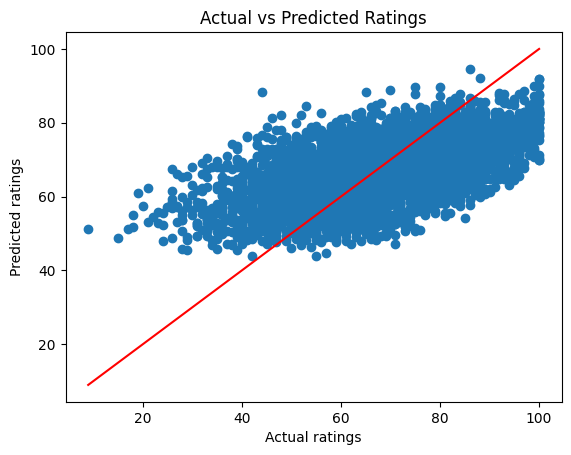

In [118]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual ratings')
plt.ylabel('Predicted ratings')
plt.title('Actual vs Predicted Ratings')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()


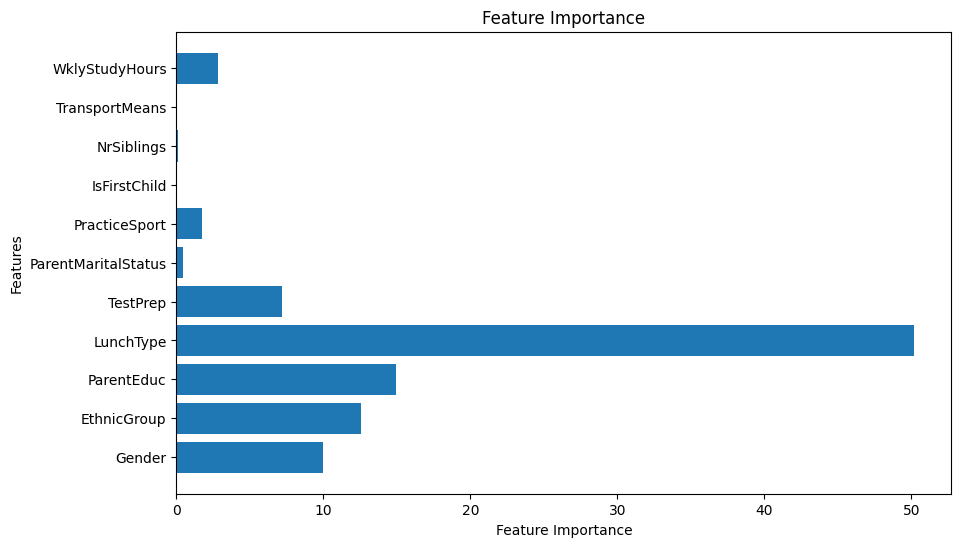

In [119]:
import matplotlib.pyplot as plt

# Получение важности признаков
feature_importances = model.get_feature_importance(train_pool)

# Визуализация важности признаков
features = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()


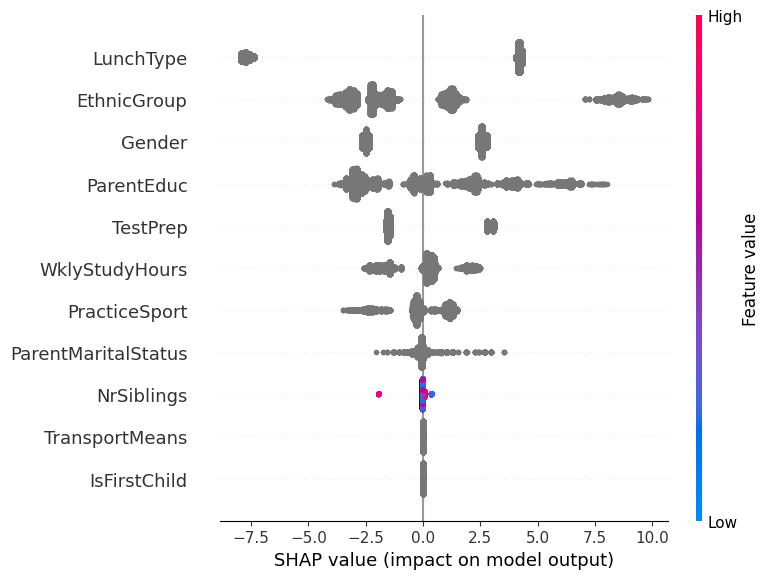

In [123]:
# Важность признаков с помощью SHAP
shap_values = model.get_feature_importance(train_pool, type="ShapValues")

# Визуализация SHAP значений для первых 100 примеров
import shap
shap.initjs()

# Преобразуем SHAP значения (последний столбец - это предсказание модели)
shap_values_without_last_column = shap_values[:, :-1]

# Построим объяснение для первых 100 наблюдений
shap.summary_plot(shap_values_without_last_column, X_train, feature_names=features)


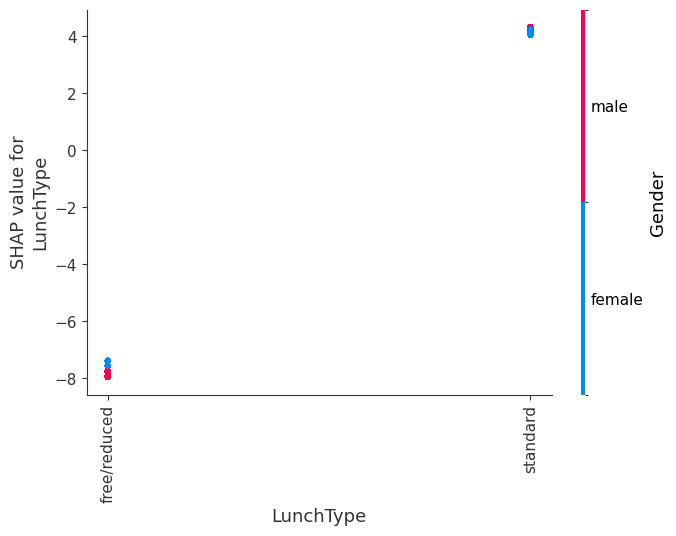

In [121]:
shap.dependence_plot("LunchType", shap_values_without_last_column, X_train)

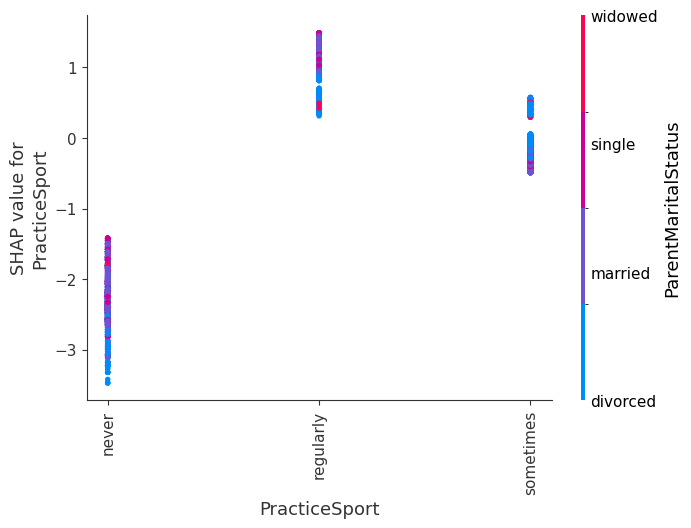

In [124]:
shap.dependence_plot("PracticeSport", shap_values_without_last_column, X_train)

In [140]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Выделим признаки и целевую переменную
X = df.drop(columns=['MathScore', 'ReadingScore', 'WritingScore'])
y = df['WritingScore']

# Разделим на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определим категориальные признаки
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Создаем пул данных с указанием категориальных признаков
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)


In [141]:

# Создаем модель CatBoost для регрессии
model = CatBoostRegressor(
    iterations=3000,         # Количество итераций
    learning_rate=0.01,       # Шаг обучения
    depth=5,                 # Глубина деревьев
    cat_features=categorical_features,
    verbose=100,             # Показ прогресса каждые 100 итераций
    random_seed=52,
)

# Обучаем модель
model.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 15.4018244	test: 15.4370123	best: 15.4370123 (0)	total: 9.2ms	remaining: 27.6s
100:	learn: 13.1489036	test: 13.0790941	best: 13.0790941 (100)	total: 371ms	remaining: 10.6s
200:	learn: 12.7510148	test: 12.6456026	best: 12.6456026 (200)	total: 617ms	remaining: 8.6s
300:	learn: 12.6297245	test: 12.5272800	best: 12.5272800 (300)	total: 883ms	remaining: 7.92s
400:	learn: 12.5740675	test: 12.4822561	best: 12.4822561 (400)	total: 1.24s	remaining: 8.03s
500:	learn: 12.5450024	test: 12.4622246	best: 12.4622246 (500)	total: 1.62s	remaining: 8.06s
600:	learn: 12.5244042	test: 12.4522420	best: 12.4522420 (600)	total: 1.9s	remaining: 7.59s
700:	learn: 12.5093259	test: 12.4453176	best: 12.4453176 (700)	total: 2.41s	remaining: 7.9s
800:	learn: 12.4980184	test: 12.4405891	best: 12.4405823 (794)	total: 3.06s	remaining: 8.42s
900:	learn: 12.4875964	test: 12.4379225	best: 12.4379216 (899)	total: 3.65s	remaining: 8.49s
1000:	learn: 12.4784320	test: 12.4359530	best: 12.4358236 (986)	total: 3.94s	

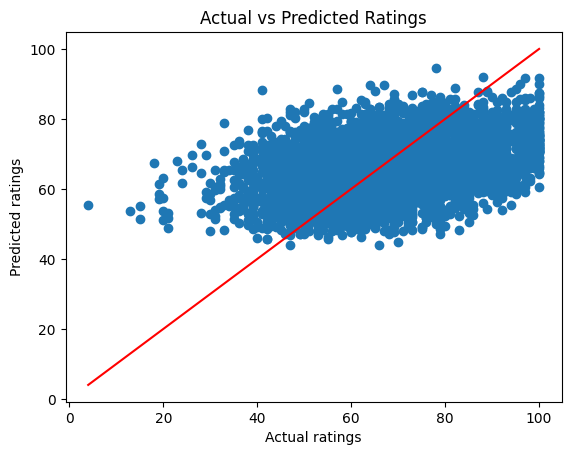

In [142]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual ratings')
plt.ylabel('Predicted ratings')
plt.title('Actual vs Predicted Ratings')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()


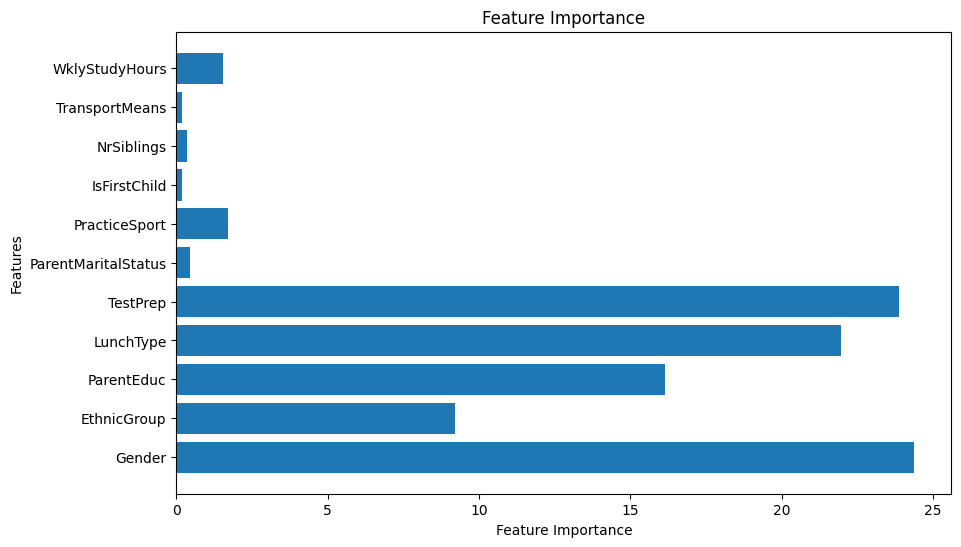

In [143]:
import matplotlib.pyplot as plt

# Получение важности признаков
feature_importances = model.get_feature_importance(train_pool)

# Визуализация важности признаков
features = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()


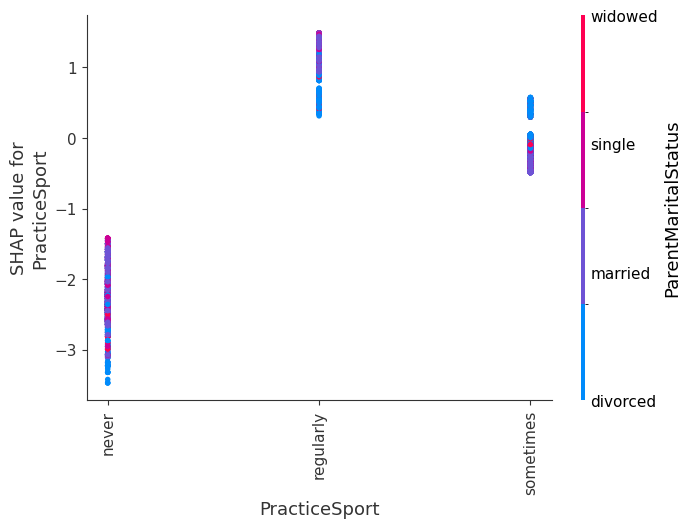

In [144]:
shap.dependence_plot("PracticeSport", shap_values_without_last_column, X_train)